In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv("/content/100.csv")  # Replace with your actual dataset file

# Extract relevant columns
time = df["time_ms"].values
ecg_signal = df["MLII"].values  # Main ECG lead
labels = df["V5"].values  # Assuming 'V5' contains arrhythmia labels

# Normalize ECG signal (Min-Max Scaling)
scaler = MinMaxScaler()
ecg_signal = scaler.fit_transform(ecg_signal.reshape(-1, 1)).flatten()

# Define window size (e.g., 200 samples per segment)
window_size = 200
stride = 50  # Overlapping window

X, y = [], []
for i in range(0, len(ecg_signal) - window_size, stride):
    X.append(ecg_signal[i : i + window_size])
    y.append(labels[i + window_size])  # Use the label at the end of the window

X = np.array(X)
y = np.array(y)

# Convert labels to categorical (One-hot encoding)
num_classes = len(np.unique(y))  # Unique arrhythmia classes
y = to_categorical(y, num_classes)

# Split dataset into Train (80%) and Test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape for LSTM input: (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)

print("Data Preprocessing Completed ✅")


Data Preprocessing Completed ✅


In [22]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming you have loaded your data in `X` (features) and `y` (labels)
# Reshape data to flatten for scaling
X = X.reshape(-1, 100)  # Flatten before scaling (100 is the window size)
scaler = StandardScaler()
X = scaler.fit_transform(X)  # Scale the features

# Reshape back to 3D for LSTM input (samples, time_steps, features)
X = X.reshape(-1, 100, 1)  # Reshape back to 3D: (samples, time_steps, features)


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Build the model with reduced dropout
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(100, 1)),  # Use correct input shape
    Dropout(0.3),  # Moderate dropout

    Bidirectional(LSTM(32)),
    Dropout(0.3),  # Moderate dropout

    Dense(32, activation='relu'),
    Dropout(0.3),  # Dropout before final layer

    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])


# Compile the model
# Compile the model for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_22 (Bidirectional)     │ (None, 100, 128)            │          33,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_23 (Bidirectional)     │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,121 (301.25 KB)

 Trainable params: 77,121 (301.25 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Build the model with reduced dropout
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(100, 1)),  # Use correct input shape
    Dropout(0.3),  # Moderate dropout

    Bidirectional(LSTM(32)),
    Dropout(0.3),  # Moderate dropout

    Dense(32, activation='relu'),
    Dropout(0.3),  # Dropout before final layer

    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))  # Convert to dictionary

# You will use class_weights when training the model



In [28]:
# Compile the model first
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with class weights and early stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,  # Increased number of epochs
    batch_size=32,
    class_weight=class_weights,  # Handle class imbalance
    callbacks=[early_stopping]  # Early stopping callback
)


Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 143ms/step - accuracy: 0.4972 - loss: 0.6940 - val_accuracy: 0.4975 - val_loss: 0.6932
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 143ms/step - accuracy: 0.4981 - loss: 0.6936 - val_accuracy: 0.4890 - val_loss: 0.6935
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - accuracy: 0.5033 - loss: 0.6935 - val_accuracy: 0.4955 - val_loss: 0.6936
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 137ms/step - accuracy: 0.4841 - loss: 0.6937 - val_accuracy: 0.4970 - val_loss: 0.6933
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 137ms/step - accuracy: 0.5066 - loss: 0.6919 - val_accuracy: 0.5080 - val_loss: 0.6932
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - accuracy: 0.4982 - loss: 0.6933 - val_accuracy: 0.5010 - val_loss: 0.6933
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 135ms/step - accuracy: 0.5173 - loss: 0.6920 - val_accuracy: 0.4970 - val_loss: 0.6931
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 139ms/step - accuracy: 0.5050 -

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4892 - loss: 0.6934
Test Accuracy: 0.5015


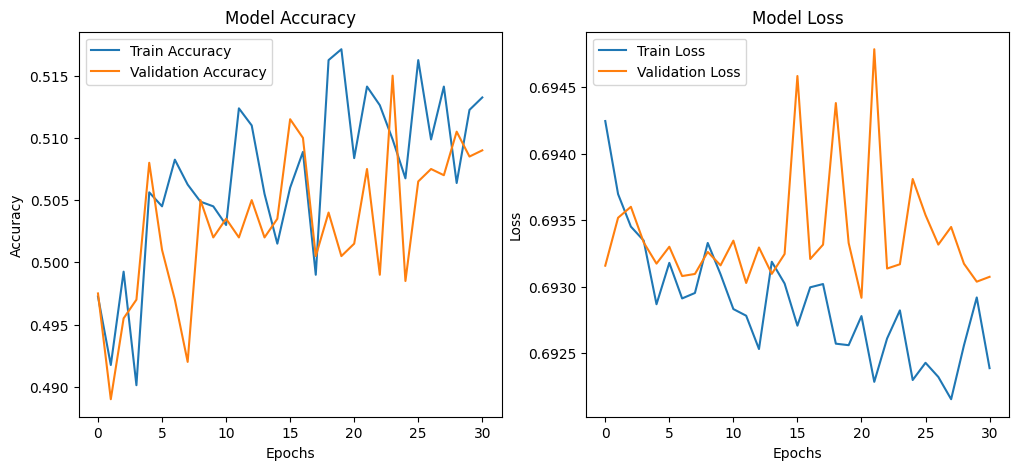

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
Confusion Matrix:
[[877 133]
 [864 126]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.87      0.64      1010
           1       0.49      0.13      0.20       990

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.42      2000
weighted avg       0.50      0.50      0.42      2000

Accuracy: 0.5015


In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Plot Accuracy and Loss curves
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.show()

# Predict the classes (for binary classification, threshold at 0.5)
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Threshold at 0.5 for binary classification

# Use y_test directly since it's 1D
y_true = y_test

# Generate Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

# Optional: Print other metrics if needed
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Optional: Print Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_true, y_pred_classes))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - accuracy: 0.4856 - loss: 0.6940 - val_accuracy: 0.5020 - val_loss: 0.6937
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 142ms/step - accuracy: 0.5118 - loss: 0.6921 - val_accuracy: 0.4940 - val_loss: 0.6933
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 45s 156ms/step - accuracy: 0.5061 - loss: 0.6936 - val_accuracy: 0.4965 - val_loss: 0.6935
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - accuracy: 0.5048 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 145ms/step - accuracy: 0.5231 - loss: 0.6933 - val_accuracy: 0.5055 - val_loss: 0.6932
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 142ms/step - accuracy: 0.4997 - loss: 0.6936 - val_accuracy: 0.4995 - val_loss: 0.6931
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 138ms/step - accuracy: 0.4932 - loss: 0.6936 - val_accuracy: 0.4950 - val_loss: 0.6938
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 138ms/step - accuracy: 0.5123 -

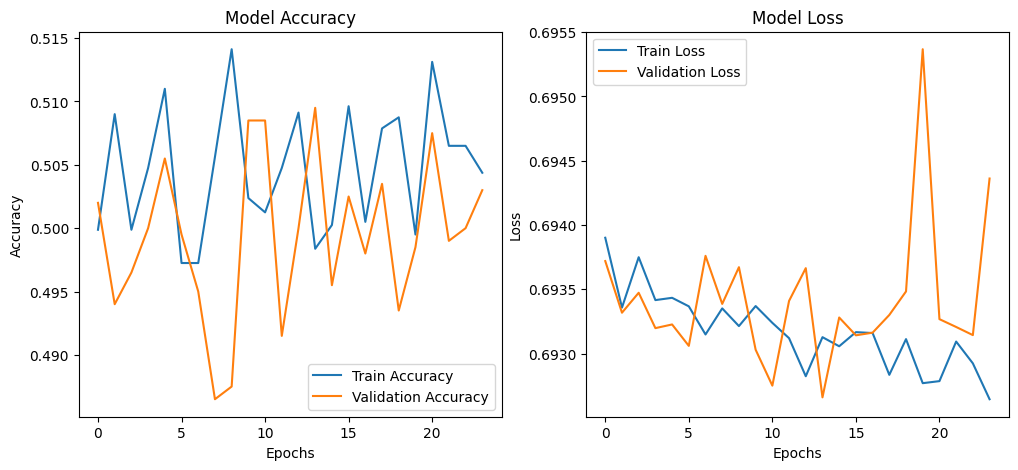

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step
Confusion Matrix:
[[870 140]
 [841 149]]
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.86      0.64      1010
           1       0.52      0.15      0.23       990

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.44      2000
weighted avg       0.51      0.51      0.44      2000



In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# Assuming your data is already loaded in X_train, y_train, X_test, y_test

# Step 1: Data Preprocessing
# Reshape X to be compatible with LSTM (3D)
X_train = X_train.reshape(-1, 100, 1)  # Make sure this is correct for your data
X_test = X_test.reshape(-1, 100, 1)

# Standardize the data (normalization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, 100))  # Flatten before scaling
X_train = X_train.reshape(-1, 100, 1)  # Reshape back to 3D for LSTM
X_test = scaler.transform(X_test.reshape(-1, 100))  # Flatten before scaling
X_test = X_test.reshape(-1, 100, 1)  # Reshape back to 3D for LSTM

# If your labels are one-hot encoded, flatten them to 1D
y_train = y_train.flatten()  # Flatten if one-hot encoded
y_test = y_test.flatten()  # Flatten if one-hot encoded

# Step 2: Model Architecture
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(100, 1)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Single output for binary classification
])

# Step 3: Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 4: Early Stopping (Adjust patience if needed)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 5: Handle Class Imbalance (if needed)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Step 6: Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# Step 7: Evaluate the Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Step 8: Plot Accuracy and Loss Curves
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.show()

# Step 9: Generate Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary classes

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

# Optional: Print other metrics if needed
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))


In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 🔹 Load your dataset (Replace this with your actual data)
# Assuming `X` is your input data and `y` is the labels
X = np.random.rand(10000, 100, 1)  # Dummy ECG data (10000 samples, 100 timesteps, 1 feature)
y = np.random.randint(0, 2, size=(10000,))  # Dummy binary labels (0 or 1)

# 🔹 Preprocess Data
scaler = StandardScaler()
X = X.reshape(-1, 100)  # Reshape for normalization
X = scaler.fit_transform(X)
X = X.reshape(-1, 100, 1)  # Reshape back for LSTM

# 🔹 Split Data into Training & Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 Define Model with Increased Dropout
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(100, 1)),
    Dropout(0.5),  # Increased dropout

    Bidirectional(LSTM(32)),
    Dropout(0.5),  # Increased dropout

    Dense(32, activation='relu'),
    Dropout(0.5),  # Dropout before final layer

    Dense(1, activation='sigmoid')  # Binary classification
])

# 🔹 Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 🔹 Early Stopping to Prevent Overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 🔹 Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

# 🔹 Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 45s 152ms/step - accuracy: 0.5102 - loss: 0.6940 - val_accuracy: 0.5030 - val_loss: 0.6934
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 148ms/step - accuracy: 0.5079 - loss: 0.6935 - val_accuracy: 0.4950 - val_loss: 0.6933
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 145ms/step - accuracy: 0.5050 - loss: 0.6939 - val_accuracy: 0.4960 - val_loss: 0.6933
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 144ms/step - accuracy: 0.5090 - loss: 0.6938 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 153ms/step - accuracy: 0.5158 - loss: 0.6928 - val_accuracy: 0.5010 - val_loss: 0.6936
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 144ms/step - accuracy: 0.5086 - loss: 0.6932 - val_accuracy: 0.4960 - val_loss: 0.6935
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - accuracy: 0.5082 - loss: 0.6930 - val_accuracy: 0.4955 - val_loss: 0.6935
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5025 - loss: 0.6933
Test Accuracy: 0.495